In [12]:
from sam2.build_sam import build_sam2
from sam2.sam2_video_predictor import SAM2VideoPredictor
import numpy as np
import torch
import cv2
import json
import matplotlib.pyplot as plt
from pathlib import Path

from typing import Any

In [13]:
# training_data_path = Path("/home/dherrera/data/elephants/new_elephant_data/")
camera_name = "zag_elp_cam_016"
# video_file = (
#     training_data_path
#     / camera_name
#     / "20240907PM/ELP-Kamera-01-20240907-185521-1725728121288-7.mp4"
# )
video_file = Path("/home/dherrera/data/elephants/identity/videos/src/identity_days/zag_elp_cam_016/ZAG-ELP-CAM-016-25.01.2025-060029-100029.mp4")

json_path = Path(str(video_file).replace(".mp4","_points.json"))

print(json_path)
with json_path.open("r") as f:
    data = json.load(f)

# Sort data
data = sorted(data, key=lambda x: x["frame"])

video = cv2.VideoCapture(video_file)
video_frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Video frames: {video_frame_count}, labelled: {len(data)}")

obj_count = np.max([len(x["records"]) for x in data])
print(f"Objects: {obj_count}")

distance_to_next_label = [
    data[i + 1]["frame"] - data[i]["frame"] for i in range(len(data) - 1)
]
distance_to_next_label.append(video_frame_count - data[-1]["frame"])
print("distance_to_next_label: ", distance_to_next_label)

/home/dherrera/data/elephants/identity/videos/src/identity_days/zag_elp_cam_016/ZAG-ELP-CAM-016-25.01.2025-060029-100029_points.json
Video frames: 360137, labelled: 54
Objects: 2
distance_to_next_label:  [12572, 21275, 1161, 774, 3094, 1934, 35395, 1777, 4606, 580, 3481, 1161, 45065, 967, 967, 8728, 262, 13253, 1741, 386, 11906, 426, 240, 194, 1740, 1354, 580, 2321, 12186, 33847, 3288, 774, 1160, 774, 580, 1354, 1741, 1353, 8124, 7156, 967, 194, 3868, 967, 5609, 1354, 3868, 967, 1161, 580, 3481, 19148, 581, 67115]


In [14]:
i = 0
data_i = data[i]
frame_index = data_i["frame"]
record_count = len(data_i["records"])
positive_points = np.stack(
    [
        np.array(x["ppoints"], dtype=np.float32).reshape((-1, 2))
        for x in data_i["records"]
    ]
)
negative_points = np.stack(
    [
        np.array(x["npoints"], dtype=np.float32).reshape((-1, 2))
        for x in data_i["records"]
    ]
)
display(positive_points.shape, positive_points)
display(negative_points.shape, negative_points)

(2, 1, 2)

array([[[1679.821  ,  601.12994]],

       [[1578.1438 , 1220.8663 ]]], dtype=float32)

(2, 0, 2)

array([], shape=(2, 0, 2), dtype=float32)

In [15]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )

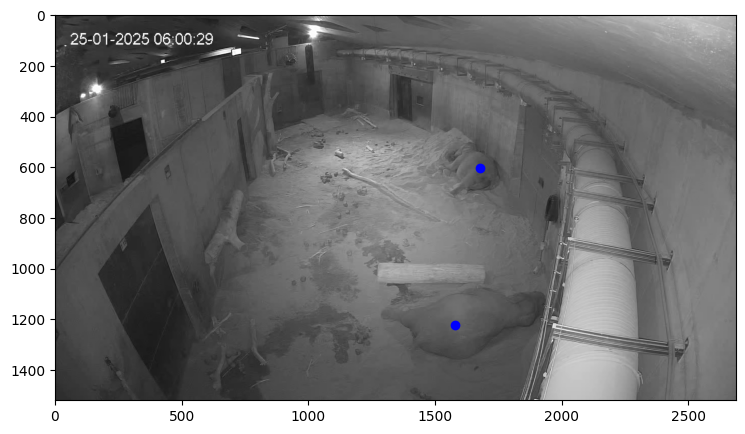

In [16]:
video.set(cv2.CAP_PROP_POS_FRAMES, data_i["frame"])
valid_frame, frame = video.read()
assert valid_frame
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(frame)
for points in positive_points:
    for p in points:
        ax.plot(p[0], p[1], "o", color="blue")
for points in negative_points:
    for p in points:
        ax.plot(p[0], p[1], "o", color="red")

In [17]:
from sam2.build_sam import build_sam2, build_sam2_video_predictor
from sam2.sam2_video_predictor import SAM2VideoPredictor

assert torch.cuda.is_available()
# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
# turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

sam2_checkpoint = "../../models/sam2/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor: SAM2VideoPredictor = build_sam2_video_predictor(
    model_cfg, sam2_checkpoint, device="cuda"
)

In [18]:
from tqdm import tqdm


def load_frames(video, ref_frame_index, frame_count):
    video.set(cv2.CAP_PROP_POS_FRAMES, ref_frame_index)
    frames = []
    for i in tqdm(range(frame_count)):
        valid, frame = video.read()
        if not valid:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    return frames


frame_count = 50  # 30*60*1
frames = load_frames(video, data_i["frame"], frame_count)
print(f"Loaded {len(frames)} images")

100%|██████████| 50/50 [00:00<00:00, 456.03it/s]

Loaded 50 images


In [19]:
inference_state = predictor.init_state(video_path=frames)

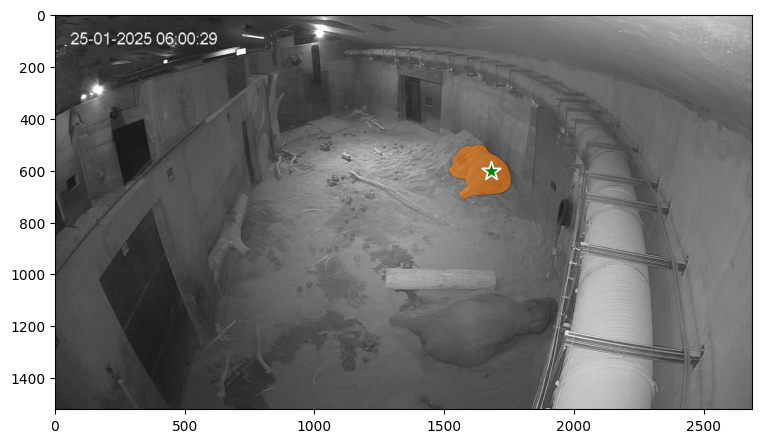

In [20]:
from typing import Any


def add_label_points(
    predictor: SAM2VideoPredictor,
    inference_state: dict[Any, Any],
    obj_id: int,
    record: dict[str, Any],
):
    ann_frame_idx = 0  # the frame index we interact with
    positive_points = np.array(record["ppoints"], dtype=np.float32).reshape((-1, 2))
    negative_points = np.array(record["npoints"], dtype=np.float32).reshape((-1, 2))

    points = np.concatenate([positive_points, negative_points])
    # for labels, `1` means positive click and `0` means negative click
    labels = np.array(
        [1] * positive_points.shape[0] + [0] * negative_points.shape[0], np.int32
    )
    _, _, mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=obj_id,
        points=points,
        labels=labels,
    )
    return points, labels, mask_logits


points, labels, mask_logits = add_label_points(
    predictor, inference_state, 1, data_i["records"][0]
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.imshow(frames[1])
show_points(points, labels, plt.gca())
show_mask((mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=1)

In [21]:
# run propagation throughout the video and collect the results in a dict
masks = []
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(
    inference_state
):
    masks.append((out_mask_logits > 0.0).cpu().numpy())

propagate in video: 100%|██████████| 50/50 [00:02<00:00, 19.96it/s]


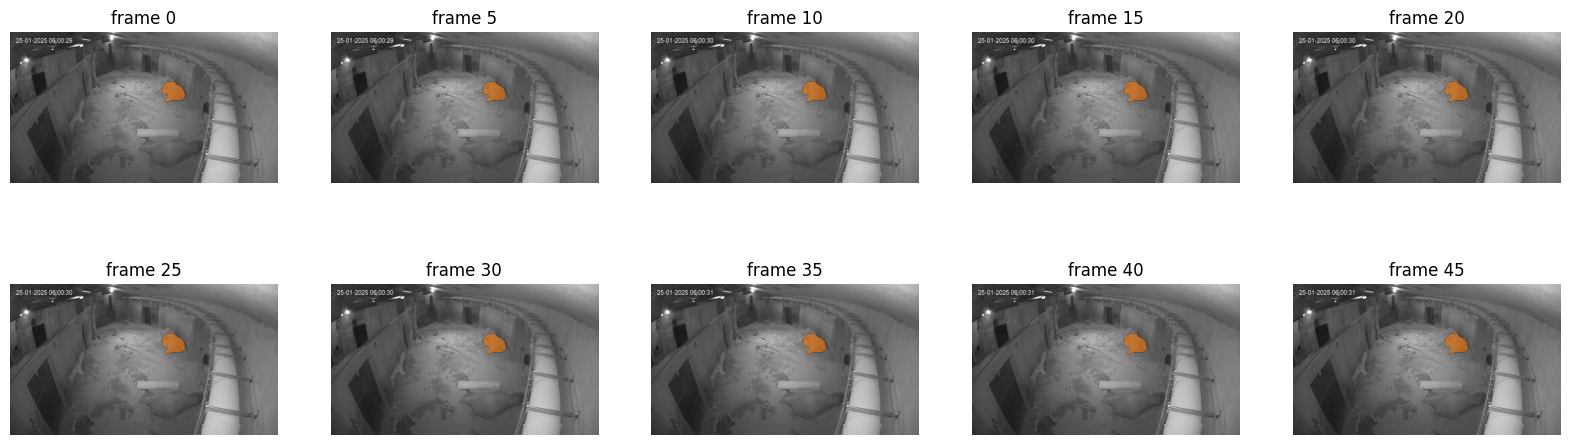

In [22]:
# render the segmentation results every few frames
vis_frame_stride = 5  # frame_count // 1
total_count = frame_count // 5
NCOLS = 5
nrows = int(np.ceil(total_count / NCOLS))
plt.close("all")
fig, axs = plt.subplots(nrows, NCOLS, figsize=(4 * NCOLS, 3 * nrows))
axs = axs.reshape((-1,))
for i, out_frame_idx in enumerate(range(0, frame_count, vis_frame_stride)):
    ax = axs[i]
    ax.set_title(f"frame {out_frame_idx}")
    ax.imshow(frames[out_frame_idx])
    ax.axis("off")
    for obj_id, mask in enumerate(masks[out_frame_idx]):
        show_mask(mask, ax, obj_id=obj_id + 1)

In [23]:
def mask_iou(a, b) -> float:
    overlap_area = (a & b).sum()
    union_area = (a | b).sum()
    iou = overlap_area / union_area
    return iou


ref_mask = None

for frame_idx, mask in enumerate(masks):
    if ref_mask is None:
        ref_mask = mask
    else:
        iou = mask_iou(ref_mask, mask)
        print(iou)

0.9803624938178221
0.9734992679355783
0.97996351738715
0.9720042169380344
0.971904357751178
0.9801314912966663
0.9799507460524409
0.9802209912705548
0.9795575631225388
0.9785422639214664
0.9771641920639055
0.9659985369422092
0.9755177815165051
0.9757725228492674
0.9752008585433768
0.9758511595506922
0.9750950625526109
0.9738254838803285
0.9736597818519378
0.9734269385860579
0.9724081963887198
0.9720605692116159
0.9680684907734135
0.9679780156204801
0.974402087259023
0.9654778636683063
0.9742251601867153
0.9656010305052989
0.9651115143710122
0.96494205782512
0.9645365168539326
0.9625987708516243
0.9621901612478417
0.9755764651216821
0.9724933193911932
0.9729509863738052
0.9726982282892827
0.9715355153203342
0.9716822375674578
0.9720056800069551
0.9720202751629254
0.9717710414314253
0.9699684943781253
0.9704801319711747
0.9708596969872874
0.970379181293336
0.9601064607645287
0.9591568237633026
0.9690315478432168


254 uint8


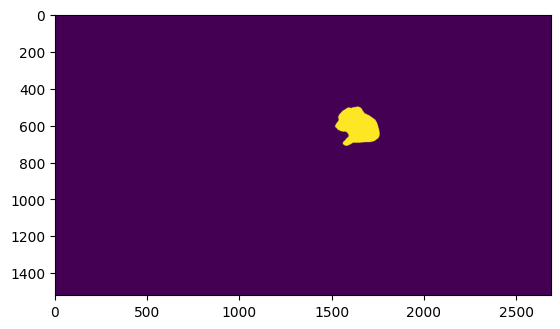

In [27]:
def segmentation_from_masks(
    obj_ids: list[int], masks: torch.Tensor
) -> torch.Tensor | None:
    AREA_THRESHOLD = 1500

    device = masks.device
    obj_count = len(obj_ids)
    intersections = torch.zeros((obj_count,), dtype=torch.int32, device=device)

    segmentation: torch.Tensor | None = None
    for i, (obj_id, mask) in enumerate(zip(obj_ids, masks)):
        mask = mask[0]
        pixel_value = 255 / obj_count * (obj_id + 1)
        if mask.sum().cpu() < AREA_THRESHOLD:
            continue

        mask_u8: torch.Tensor = (mask * pixel_value).to(torch.uint8)
        if segmentation is None:
            segmentation = mask_u8
        else:
            intersections[i] = (segmentation & mask_u8).sum()
            segmentation = segmentation + mask_u8

    # Check intersections
    all_intersections = intersections.sum().cpu()
    if all_intersections > 0:
        print(f"Warning: the different labels overlap by {all_intersections} px.")
    return segmentation


segmentation = segmentation_from_masks(out_obj_ids, out_mask_logits > 0.0).cpu().numpy()
print(segmentation.max(), segmentation.dtype)
plt.imshow(segmentation)
# show_mask((out_mask_logits[0]>0.0).cpu().numpy(),plt.gca(),1)

In [25]:
from pathlib import Path


def save_frame(
    path_prefix: Path, index: int, frame: np.ndarray, segmentation: np.ndarray
) -> None:
    path_prefix.parent.mkdir(exist_ok=True, parents=True)
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f"{str(path_prefix)}_{index:08d}_img.jpg", frame_bgr, [cv2.IMWRITE_JPEG_QUALITY,90])
    # cv2.imwrite(f"{str(path_prefix)}_{index:08d}_img.png", frame_bgr)
    cv2.imwrite(f"{str(path_prefix)}_{index:08d}_seg.png", segmentation)


def make_path_prefix(camera_name: str, video_file: Path) -> Path:
    DATA_DIR = Path("/home/dherrera/data/elephants/training_data")
    prefix = DATA_DIR / camera_name / video_file.name.replace(".mp4","")
    return prefix


save_frame(make_path_prefix(camera_name, video_file), 0, frames[0], segmentation)

In [28]:
import gc

IOU_THRESHOLD = 0.9
MAX_FRAME_COUNT = 500
prefix = make_path_prefix(camera_name, video_file)
for i, data_i in enumerate(tqdm(data, "Labelled frames")):
    frame_count = min(MAX_FRAME_COUNT, distance_to_next_label[i])
    ref_frame_idx = data_i["frame"]
    frames = load_frames(video, ref_frame_idx, frame_count)
    if "inference_state" in locals():
        del inference_state
    gc.collect()
    inference_state = predictor.init_state(video_path=frames)

    for i, record in enumerate(data_i["records"]):
        add_label_points(predictor, inference_state, i, record)

    ref_masks = None

    for sam_frame_idx, obj_ids, mask_logits in predictor.propagate_in_video(
        inference_state
    ):
        if sam_frame_idx % 10 != 0:
            continue

        video_frame_idx = ref_frame_idx + sam_frame_idx

        masks = mask_logits > 0.0
        if ref_masks is None:
            ref_masks = masks
        else:
            iou = mask_iou(ref_masks, masks).cpu().item()
            if iou > IOU_THRESHOLD:
                print(f"Skipping {video_frame_idx} iou={iou}")
                continue
            ref_masks = masks

        segmentation_image = segmentation_from_masks(obj_ids, masks)
        if segmentation_image is None:
            break
        segmentation_image = segmentation_image.cpu().numpy()

        save_frame(prefix, video_frame_idx, frames[sam_frame_idx], segmentation_image)

100%|██████████| 500/500 [00:01<00:00, 495.98it/s]it/s]


Skipping 10 iou=0.9793006181716919


Skipping 20 iou=0.9839914441108704


Skipping 30 iou=0.981924831867218


Skipping 40 iou=0.9830852746963501


Skipping 50 iou=0.9817343950271606


Skipping 60 iou=0.9774274826049805


Skipping 70 iou=0.9800419211387634


Skipping 80 iou=0.9833064079284668


Skipping 90 iou=0.9805541038513184


Skipping 100 iou=0.9823747277259827


Skipping 110 iou=0.9813978672027588


Skipping 120 iou=0.9807383418083191


Skipping 130 iou=0.9818137884140015


Skipping 140 iou=0.9796411395072937


Skipping 150 iou=0.9828699231147766


Skipping 160 iou=0.9825712442398071


Skipping 170 iou=0.9818506240844727


Skipping 180 iou=0.9839147925376892


Skipping 190 iou=0.9773609042167664


Skipping 200 iou=0.9837301969528198


Skipping 210 iou=0.9835358262062073


Skipping 220 iou=0.9777398109436035


Skipping 230 iou=0.9824702739715576


Skipping 240 iou=0.9808200001716614


Skipping 250 iou=0.9820550680160522


Skipping 260 iou=0.98399418592453


Skipping 270 iou=0.9776395559310913


Skipping 280 iou=0.9821521043777466


Skipping 290 iou=0.9802802205085754


Skipping 300 iou=0.9800347089767456


Skipping 310 iou=0.980271577835083


Skipping 320 iou=0.9792158603668213


Skipping 330 iou=0.9817742705345154


Skipping 340 iou=0.9791277647018433


Skipping 350 iou=0.980630099773407


Skipping 360 iou=0.9806888699531555


Skipping 370 iou=0.9778807163238525


Skipping 380 iou=0.9785516858100891


Skipping 390 iou=0.9808613657951355


Skipping 400 iou=0.9811808466911316


Skipping 410 iou=0.9823598265647888


Skipping 420 iou=0.9817373752593994


Skipping 430 iou=0.9834135174751282


Skipping 440 iou=0.9795624017715454


Skipping 450 iou=0.9809479117393494


Skipping 460 iou=0.9796126484870911


Skipping 470 iou=0.9799960255622864


Skipping 480 iou=0.9822638630867004


Skipping 490 iou=0.9813984036445618


100%|██████████| 500/500 [00:01<00:00, 498.91it/s]8, 33.94s/it]


Skipping 12582 iou=0.975756824016571


Skipping 12592 iou=0.9731510281562805


Skipping 12602 iou=0.9746036529541016


Skipping 12612 iou=0.9741256833076477


Skipping 12622 iou=0.9693588018417358


Skipping 12632 iou=0.9715739488601685


Skipping 12642 iou=0.9743313789367676


Skipping 12652 iou=0.9713792204856873


Skipping 12662 iou=0.9728816151618958


Skipping 12672 iou=0.9743587970733643


Skipping 12682 iou=0.9732348918914795


Skipping 12692 iou=0.9715381860733032


Skipping 12702 iou=0.9714906811714172


Skipping 12712 iou=0.969930112361908


Skipping 12722 iou=0.9722400307655334


Skipping 12732 iou=0.9735011458396912


Skipping 12742 iou=0.974090576171875


Skipping 12752 iou=0.9745004773139954


Skipping 12762 iou=0.9739737510681152


Skipping 12772 iou=0.9698020815849304


Skipping 12782 iou=0.9730973243713379


Skipping 12792 iou=0.9733944535255432


Skipping 12802 iou=0.9752769470214844


Skipping 12812 iou=0.9735312461853027


Skipping 12822 iou=0.9746334552764893


Skipping 12832 iou=0.973260760307312


Skipping 12842 iou=0.9746274352073669


Skipping 12852 iou=0.972404420375824


Skipping 12862 iou=0.9767671227455139


Skipping 12872 iou=0.9784447550773621


Skipping 12882 iou=0.976093590259552


Skipping 12892 iou=0.9764113426208496


Skipping 12902 iou=0.9764156937599182


Skipping 12912 iou=0.9755964279174805


Skipping 12922 iou=0.9762958884239197


Skipping 12932 iou=0.9711501598358154


Skipping 12942 iou=0.972341775894165


Skipping 12952 iou=0.9751485586166382


Skipping 12962 iou=0.9734370112419128


Skipping 12972 iou=0.974797785282135


Skipping 12982 iou=0.9727432131767273


Skipping 12992 iou=0.9749423861503601


Skipping 13002 iou=0.9708865880966187


Skipping 13012 iou=0.9717701077461243


Skipping 13022 iou=0.9732029438018799


Skipping 13032 iou=0.9725424647331238


Skipping 13042 iou=0.9725258946418762


Skipping 13052 iou=0.9740866422653198


Skipping 13062 iou=0.9701566100120544


100%|██████████| 500/500 [00:00<00:00, 517.01it/s]1, 34.07s/it]


Skipping 33957 iou=0.9063408374786377


Skipping 33977 iou=0.9498620629310608


Skipping 33987 iou=0.9371271133422852


Skipping 33997 iou=0.9122878909111023


Skipping 34017 iou=0.9179654717445374


Skipping 34037 iou=0.939257800579071


Skipping 34047 iou=0.9021391272544861


Skipping 34067 iou=0.9685558676719666


Skipping 34077 iou=0.9566686749458313


Skipping 34087 iou=0.9370307326316833


Skipping 34107 iou=0.9726642966270447


Skipping 34117 iou=0.9533783197402954


Skipping 34127 iou=0.942251980304718


Skipping 34147 iou=0.9289528131484985


Skipping 34157 iou=0.9070092439651489


Skipping 34177 iou=0.9630053639411926


Skipping 34187 iou=0.9023944139480591


Skipping 34207 iou=0.9229288101196289


Skipping 34217 iou=0.9015601873397827


Skipping 34237 iou=0.9192490577697754


Skipping 34257 iou=0.9136292338371277


Skipping 34277 iou=0.9352729320526123


Skipping 34287 iou=0.9174321293830872


Skipping 34307 iou=0.9278109073638916


Skipping 34327 iou=0.923632025718689


100%|██████████| 500/500 [00:00<00:00, 500.68it/s]5, 34.24s/it]


Skipping 35018 iou=0.9689329266548157


Skipping 35028 iou=0.9701496362686157


Skipping 35038 iou=0.9713488221168518


Skipping 35048 iou=0.9714029431343079


Skipping 35058 iou=0.9700851440429688


Skipping 35068 iou=0.9663943648338318


Skipping 35078 iou=0.9593241214752197


Skipping 35088 iou=0.9652507901191711


Skipping 35098 iou=0.9647588133811951


Skipping 35108 iou=0.9560996294021606


Skipping 35118 iou=0.9572668671607971


Skipping 35128 iou=0.9562581777572632


Skipping 35138 iou=0.9493761658668518


Skipping 35148 iou=0.948906421661377


Skipping 35158 iou=0.9419252872467041


Skipping 35168 iou=0.9473652839660645


Skipping 35178 iou=0.9409193992614746


Skipping 35188 iou=0.938322901725769


Skipping 35198 iou=0.9279248714447021


Skipping 35208 iou=0.9321542382240295


Skipping 35218 iou=0.9242243766784668


Skipping 35228 iou=0.9266222715377808


Skipping 35238 iou=0.9328241944313049


Skipping 35248 iou=0.9253722429275513


Skipping 35258 iou=0.9201765656471252


Skipping 35268 iou=0.9213701486587524


Skipping 35278 iou=0.9239228367805481


Skipping 35288 iou=0.912932813167572


Skipping 35298 iou=0.9030085206031799


Skipping 35318 iou=0.9651961326599121


Skipping 35328 iou=0.9663075804710388


Skipping 35338 iou=0.959837794303894


Skipping 35348 iou=0.9429646730422974


Skipping 35358 iou=0.9405920505523682


Skipping 35368 iou=0.9351433515548706


Skipping 35378 iou=0.9120018482208252


Skipping 35428 iou=0.9288344979286194


Skipping 35438 iou=0.9222224950790405


Skipping 35458 iou=0.9559913873672485


Skipping 35468 iou=0.9079568982124329


Skipping 35488 iou=0.9791606068611145


Skipping 35498 iou=0.9020442962646484


100%|██████████| 500/500 [00:01<00:00, 492.97it/s]6, 34.33s/it]


Skipping 35792 iou=0.9506064653396606


Skipping 35802 iou=0.9539186954498291


Skipping 35812 iou=0.9415779113769531


Skipping 35822 iou=0.9369339346885681


Skipping 35832 iou=0.9322981834411621


Skipping 35842 iou=0.9015791416168213


Skipping 35862 iou=0.9632582068443298


Skipping 35872 iou=0.955480694770813


Skipping 35882 iou=0.9329288601875305


Skipping 35902 iou=0.9372692108154297


Skipping 35912 iou=0.9274645447731018


Skipping 35922 iou=0.912177562713623


Skipping 35942 iou=0.9432156085968018


Skipping 35952 iou=0.9312430620193481


Skipping 35962 iou=0.9186574220657349


Skipping 35972 iou=0.9059858322143555


Skipping 35982 iou=0.9030709266662598


Skipping 36002 iou=0.9721900224685669


Skipping 36012 iou=0.9419423937797546


Skipping 36022 iou=0.9270930886268616


Skipping 36032 iou=0.9208793640136719


Skipping 36042 iou=0.9233413934707642


Skipping 36052 iou=0.9155068397521973


Skipping 36062 iou=0.9091957211494446


Skipping 36082 iou=0.9681700468063354


Skipping 36092 iou=0.944914698600769


Skipping 36102 iou=0.9293560981750488


Skipping 36112 iou=0.9194559454917908


Skipping 36132 iou=0.9730306267738342


Skipping 36142 iou=0.9317319989204407


Skipping 36152 iou=0.9143684506416321


Skipping 36162 iou=0.9011381268501282


Skipping 36172 iou=0.9117526412010193


Skipping 36182 iou=0.911159098148346


Skipping 36202 iou=0.9552995562553406


Skipping 36252 iou=0.9010464549064636


100%|██████████| 500/500 [00:00<00:00, 512.58it/s]5, 34.40s/it]


Skipping 38886 iou=0.9692851305007935


Skipping 38896 iou=0.9707202315330505


Skipping 38906 iou=0.9633892178535461


Skipping 38916 iou=0.9727116823196411


Skipping 38926 iou=0.9677596688270569


Skipping 38936 iou=0.9639774560928345


Skipping 38946 iou=0.9727397561073303


Skipping 38956 iou=0.97152179479599


Skipping 38966 iou=0.9710263609886169


Skipping 38976 iou=0.9541553258895874


Skipping 38986 iou=0.9555960297584534


Skipping 38996 iou=0.9714424014091492


Skipping 39006 iou=0.9665132761001587


Skipping 39016 iou=0.9571693539619446


Skipping 39026 iou=0.9549190402030945


Skipping 39036 iou=0.9543507695198059


Skipping 39046 iou=0.9593765139579773


Skipping 39056 iou=0.9682391285896301


Skipping 39066 iou=0.9745666980743408


Skipping 39076 iou=0.965299129486084


Skipping 39086 iou=0.9494810700416565


Skipping 39096 iou=0.9677064418792725


Skipping 39106 iou=0.9573583602905273


Skipping 39116 iou=0.9659569263458252


Skipping 39126 iou=0.9544287919998169


Skipping 39136 iou=0.9641497135162354


Skipping 39146 iou=0.9647147059440613


Skipping 39156 iou=0.9587594866752625


Skipping 39166 iou=0.9672486186027527


Skipping 39176 iou=0.9562197327613831


Skipping 39186 iou=0.9653143882751465


Skipping 39196 iou=0.9628341197967529


Skipping 39206 iou=0.961735188961029


Skipping 39216 iou=0.9642335772514343


Skipping 39226 iou=0.9601097702980042


Skipping 39236 iou=0.9528719782829285


Skipping 39246 iou=0.9712748527526855


Skipping 39256 iou=0.9569073915481567


Skipping 39266 iou=0.9616199731826782


Skipping 39276 iou=0.9667266011238098


Skipping 39286 iou=0.9591475129127502


Skipping 39296 iou=0.9603795409202576


Skipping 39306 iou=0.9582127928733826


Skipping 39316 iou=0.967051088809967


Skipping 39326 iou=0.9708078503608704


Skipping 39336 iou=0.9613423943519592


Skipping 39346 iou=0.9609696269035339


Skipping 39356 iou=0.9590550065040588


Skipping 39366 iou=0.9631816148757935


100%|██████████| 500/500 [00:01<00:00, 431.88it/s]6, 32.85s/it]


Skipping 40890 iou=0.9223201870918274


Skipping 40900 iou=0.910914421081543


Skipping 40920 iou=0.9457157850265503


Skipping 40930 iou=0.9053162336349487


Skipping 40950 iou=0.9080118536949158


Skipping 40970 iou=0.9127699136734009


Skipping 40990 iou=0.9725269675254822


Skipping 41000 iou=0.9378432035446167


Skipping 41010 iou=0.9292990565299988


Skipping 41020 iou=0.9286935925483704


Skipping 41030 iou=0.9229699373245239


Skipping 41040 iou=0.9117798209190369


Skipping 41050 iou=0.9038787484169006


Skipping 41060 iou=0.9283932447433472


Skipping 41070 iou=0.9201294779777527


Skipping 41080 iou=0.9210754036903381


Skipping 41090 iou=0.9192428588867188


Skipping 41100 iou=0.9254519939422607


Skipping 41110 iou=0.91855788230896


Skipping 41120 iou=0.9256054759025574


Skipping 41130 iou=0.9251611828804016


Skipping 41140 iou=0.9207715392112732


Skipping 41150 iou=0.9196683168411255


Skipping 41160 iou=0.9361870288848877


Skipping 41170 iou=0.9059587717056274


Skipping 41190 iou=0.9761798977851868


Skipping 41200 iou=0.9324775338172913


Skipping 41210 iou=0.9248208403587341


Skipping 41220 iou=0.9194576144218445


Skipping 41230 iou=0.9053019881248474


Skipping 41250 iou=0.9377686381340027


Skipping 41260 iou=0.9105941653251648


Skipping 41280 iou=0.9640334248542786


Skipping 41290 iou=0.9087013006210327


100%|██████████| 500/500 [00:01<00:00, 492.87it/s]6, 31.62s/it]


Skipping 76215 iou=0.9577193856239319


Skipping 76225 iou=0.9455347061157227


Skipping 76235 iou=0.945127010345459


Skipping 76245 iou=0.9425647854804993


Skipping 76255 iou=0.9421705603599548


Skipping 76265 iou=0.9368671774864197


Skipping 76275 iou=0.9368423819541931


Skipping 76285 iou=0.9331801533699036


Skipping 76295 iou=0.9150897860527039


Skipping 76305 iou=0.907521665096283


Skipping 76315 iou=0.9030408263206482


Skipping 76335 iou=0.9805893301963806


Skipping 76345 iou=0.9549753069877625


Skipping 76355 iou=0.9489388465881348


Skipping 76365 iou=0.9354045987129211


Skipping 76375 iou=0.9183308482170105


Skipping 76395 iou=0.9529778361320496


Skipping 76405 iou=0.9421127438545227


Skipping 76415 iou=0.9001538753509521


Skipping 76425 iou=0.9073101282119751


Skipping 76445 iou=0.9480317234992981


Skipping 76455 iou=0.9117206931114197


Skipping 76475 iou=0.9470354914665222


Skipping 76485 iou=0.9132178425788879


Skipping 76505 iou=0.9401028752326965


Skipping 76525 iou=0.9284912347793579


Skipping 76545 iou=0.9397976398468018


Skipping 76565 iou=0.9288659691810608


Skipping 76585 iou=0.9773149490356445


Skipping 76595 iou=0.9655749797821045


Skipping 76605 iou=0.9530919790267944


Skipping 76615 iou=0.9513086080551147


Skipping 76625 iou=0.9525238871574402


Skipping 76635 iou=0.9482195973396301


Skipping 76645 iou=0.9455938339233398


Skipping 76655 iou=0.9371911883354187


Skipping 76665 iou=0.9318198561668396


Skipping 76675 iou=0.9350627064704895


Skipping 76685 iou=0.9435964226722717


Skipping 76695 iou=0.9528607130050659


100%|██████████| 500/500 [00:00<00:00, 520.26it/s]8, 32.57s/it]


Skipping 77992 iou=0.9703173637390137


Skipping 78002 iou=0.9669966101646423


Skipping 78012 iou=0.9623330235481262


Skipping 78022 iou=0.9664011001586914


Skipping 78032 iou=0.9644404053688049


Skipping 78042 iou=0.9633157849311829


Skipping 78052 iou=0.9587562680244446


Skipping 78062 iou=0.9544661641120911


Skipping 78072 iou=0.9483668208122253


Skipping 78082 iou=0.9439535737037659


Skipping 78092 iou=0.9434994459152222


Skipping 78102 iou=0.9425457119941711


Skipping 78112 iou=0.9456644654273987


Skipping 78122 iou=0.9399242997169495


Skipping 78132 iou=0.9169073700904846


Skipping 78142 iou=0.914962112903595


Skipping 78152 iou=0.90324467420578


Skipping 78172 iou=0.920739471912384


Skipping 78192 iou=0.96256023645401


Skipping 78202 iou=0.9473889470100403


Skipping 78222 iou=0.9370864033699036


Skipping 78232 iou=0.9107728004455566


Skipping 78252 iou=0.9678963422775269


Skipping 78262 iou=0.9067957997322083


Skipping 78272 iou=0.9044460654258728


Skipping 78292 iou=0.932118833065033


Skipping 78312 iou=0.9591597318649292


Skipping 78322 iou=0.9351952075958252


Skipping 78332 iou=0.9349873065948486


Skipping 78342 iou=0.9294635653495789


Skipping 78352 iou=0.9011110067367554


Skipping 78372 iou=0.9394463896751404


Skipping 78392 iou=0.9657316207885742


Skipping 78402 iou=0.9412142038345337


Skipping 78422 iou=0.9641081094741821


Skipping 78432 iou=0.9363352656364441


Skipping 78452 iou=0.96525639295578


Skipping 78462 iou=0.9469018578529358


Skipping 78472 iou=0.9569658041000366


100%|██████████| 500/500 [00:01<00:00, 490.22it/s]1, 33.14s/it]


Skipping 82598 iou=0.9756009578704834


Skipping 82608 iou=0.972834587097168


Skipping 82618 iou=0.9683982729911804


Skipping 82628 iou=0.9698802828788757


Skipping 82638 iou=0.9679220914840698


Skipping 82648 iou=0.9710374474525452


Skipping 82658 iou=0.9693295359611511


Skipping 82668 iou=0.9664318561553955


Skipping 82678 iou=0.9682221412658691


Skipping 82688 iou=0.9634568095207214


Skipping 82698 iou=0.9681698083877563


Skipping 82708 iou=0.9689471125602722


Skipping 82718 iou=0.9665042757987976


Skipping 82728 iou=0.9624048471450806


Skipping 82738 iou=0.9404128193855286


Skipping 82748 iou=0.918711245059967


Skipping 82768 iou=0.9450649619102478


Skipping 82778 iou=0.9264941811561584


Skipping 82788 iou=0.9248239994049072


Skipping 82798 iou=0.9145383834838867


Skipping 82808 iou=0.9108424186706543


Skipping 82828 iou=0.9402193427085876


Skipping 82838 iou=0.9340183734893799


Skipping 82848 iou=0.9333591461181641


Skipping 82858 iou=0.9402133822441101


Skipping 82868 iou=0.9398037791252136


Skipping 82878 iou=0.9442790746688843


Skipping 82888 iou=0.9544702768325806


Skipping 82898 iou=0.9627478122711182


Skipping 82908 iou=0.9540756344795227


Skipping 82918 iou=0.9178063273429871


Skipping 82928 iou=0.905392587184906


Skipping 82938 iou=0.9109693765640259


Skipping 82948 iou=0.9117599129676819


Skipping 82958 iou=0.9152054786682129


Skipping 82968 iou=0.9047005772590637


Skipping 82988 iou=0.9636743664741516


Skipping 82998 iou=0.9488052129745483


Skipping 83008 iou=0.9450803399085999


Skipping 83018 iou=0.9377582669258118


Skipping 83028 iou=0.934468150138855


Skipping 83038 iou=0.9334908127784729


Skipping 83048 iou=0.9270697236061096


Skipping 83058 iou=0.9095469117164612


Skipping 83068 iou=0.905189573764801


Skipping 83078 iou=0.9104090332984924


100%|██████████| 500/500 [00:01<00:00, 487.14it/s]37, 33.57s/it]


Skipping 83178 iou=0.9649877548217773


Skipping 83188 iou=0.9389302730560303


Skipping 83198 iou=0.9261473417282104


Skipping 83208 iou=0.9133274555206299


Skipping 83218 iou=0.9028859734535217


Skipping 83228 iou=0.9007564187049866


Skipping 83248 iou=0.9873294234275818


Skipping 83258 iou=0.9782112240791321


Skipping 83268 iou=0.9707895517349243


Skipping 83278 iou=0.9595805406570435


Skipping 83288 iou=0.9510214328765869


Skipping 83298 iou=0.9456579089164734


Skipping 83308 iou=0.9341418743133545


Skipping 83318 iou=0.9295324087142944


Skipping 83328 iou=0.9288720488548279


Skipping 83338 iou=0.9247251152992249


Skipping 83348 iou=0.926426112651825


Skipping 83358 iou=0.9280763268470764


Skipping 83368 iou=0.9254427552223206


Skipping 83378 iou=0.9366657137870789


Skipping 83388 iou=0.9383797645568848


Skipping 83398 iou=0.9384207725524902


Skipping 83408 iou=0.9374229311943054


Skipping 83418 iou=0.9300341010093689


Skipping 83428 iou=0.9298892021179199


Skipping 83438 iou=0.9233453273773193


Skipping 83448 iou=0.9092675447463989


Skipping 83468 iou=0.9615401029586792


Skipping 83478 iou=0.9529721736907959


Skipping 83488 iou=0.9463597536087036


Skipping 83498 iou=0.9204180240631104


Skipping 83508 iou=0.9174055457115173


Skipping 83518 iou=0.9173856973648071


Skipping 83538 iou=0.9382186532020569


Skipping 83548 iou=0.9115551710128784


Skipping 83568 iou=0.9505046606063843


Skipping 83578 iou=0.9222370982170105


Skipping 83598 iou=0.9462574124336243


Skipping 83608 iou=0.931321918964386


Skipping 83628 iou=0.9517156481742859


Skipping 83638 iou=0.9401081204414368


Skipping 83648 iou=0.9248840808868408


Skipping 83658 iou=0.9059709310531616


100%|██████████| 500/500 [00:00<00:00, 511.25it/s]15, 33.85s/it]


Skipping 86659 iou=0.9683952331542969


Skipping 86669 iou=0.9686530232429504


Skipping 86679 iou=0.971375584602356


Skipping 86689 iou=0.9650958180427551


Skipping 86699 iou=0.9732998609542847


Skipping 86709 iou=0.9455569386482239


Skipping 86719 iou=0.9305947422981262


Skipping 86729 iou=0.9076159596443176


Skipping 86749 iou=0.9221695065498352


Skipping 86769 iou=0.9287551045417786


Skipping 86789 iou=0.9622951745986938


Skipping 86799 iou=0.932925283908844


Skipping 86819 iou=0.9360238313674927


Skipping 86829 iou=0.9104372262954712


Skipping 86849 iou=0.9258422255516052


Skipping 86889 iou=0.944399356842041


Skipping 86899 iou=0.9097265005111694


Skipping 86919 iou=0.965925931930542


Skipping 86929 iou=0.9220684170722961


Skipping 86949 iou=0.9276036620140076


Skipping 86969 iou=0.9503196477890015


Skipping 86979 iou=0.929780125617981


Skipping 86989 iou=0.9213590025901794


Skipping 87009 iou=0.9311292171478271


Skipping 87029 iou=0.9336594939231873


Skipping 87049 iou=0.9491603374481201


Skipping 87059 iou=0.9305822253227234


Skipping 87069 iou=0.9178124070167542


Skipping 87079 iou=0.9099646806716919


Skipping 87089 iou=0.9039326310157776


Skipping 87109 iou=0.9778533577919006


Skipping 87119 iou=0.962530255317688


Skipping 87129 iou=0.9424065351486206


Skipping 87139 iou=0.9491991996765137


100%|██████████| 500/500 [00:00<00:00, 511.45it/s]36, 32.31s/it]


Skipping 87870 iou=0.9127420783042908


Skipping 87940 iou=0.9032755494117737


Skipping 87970 iou=0.9076622128486633


Skipping 87990 iou=0.9060700535774231


Skipping 88020 iou=0.9035553932189941


Skipping 88040 iou=0.9155192375183105


Skipping 88050 iou=0.9051914215087891


Skipping 88130 iou=0.9385051727294922


Skipping 88140 iou=0.907384991645813


Skipping 88160 iou=0.9716746211051941


Skipping 88170 iou=0.9743310213088989


Skipping 88180 iou=0.9830322861671448


Skipping 88190 iou=0.9634795784950256


Skipping 88200 iou=0.9603435397148132


Skipping 88210 iou=0.9612035751342773


Skipping 88220 iou=0.9675069451332092


Skipping 88230 iou=0.970563530921936


Skipping 88240 iou=0.9737468361854553


Skipping 88250 iou=0.968480110168457


Skipping 88260 iou=0.9593390822410583


Skipping 88270 iou=0.9621304869651794


Skipping 88280 iou=0.9586180448532104


Skipping 88290 iou=0.9434437155723572


Skipping 88300 iou=0.9521592855453491


100%|██████████| 500/500 [00:01<00:00, 493.93it/s]22, 31.27s/it]


Skipping 132885 iou=0.9785189628601074


Skipping 132895 iou=0.976154088973999


Skipping 132905 iou=0.9771127104759216


Skipping 132915 iou=0.9746614694595337


Skipping 132925 iou=0.9651015400886536


Skipping 132935 iou=0.9634000658988953


Skipping 132945 iou=0.9704644680023193


Skipping 132955 iou=0.9696117639541626


Skipping 132965 iou=0.9696327447891235


Skipping 132975 iou=0.960673451423645


Skipping 132985 iou=0.9614875316619873


Skipping 132995 iou=0.9595907330513


Skipping 133005 iou=0.9637452363967896


Skipping 133015 iou=0.9614013433456421


Skipping 133025 iou=0.949507474899292


Skipping 133035 iou=0.9527771472930908


Skipping 133045 iou=0.9591644406318665


Skipping 133055 iou=0.9601664543151855


Skipping 133065 iou=0.9591816663742065


Skipping 133075 iou=0.9652431011199951


Skipping 133085 iou=0.967991828918457


Skipping 133095 iou=0.9672619104385376


Skipping 133105 iou=0.9690239429473877


Skipping 133115 iou=0.9662286043167114


Skipping 133125 iou=0.9687862396240234


Skipping 133135 iou=0.9646549820899963


Skipping 133145 iou=0.9615004658699036


Skipping 133155 iou=0.9634300470352173


Skipping 133165 iou=0.9633097648620605


Skipping 133175 iou=0.966431200504303


Skipping 133185 iou=0.9628793001174927


Skipping 133195 iou=0.9661294221878052


Skipping 133205 iou=0.9648236036300659


Skipping 133215 iou=0.9656850695610046


Skipping 133225 iou=0.9668527245521545


Skipping 133235 iou=0.9650883078575134


Skipping 133245 iou=0.961625874042511


Skipping 133255 iou=0.963193953037262


Skipping 133265 iou=0.9617549777030945


Skipping 133275 iou=0.9642830491065979


Skipping 133285 iou=0.9623122811317444


Skipping 133295 iou=0.9566790461540222


Skipping 133305 iou=0.9666914343833923


Skipping 133315 iou=0.9638249278068542


Skipping 133325 iou=0.9637356400489807


Skipping 133335 iou=0.9643464684486389


Skipping 133345 iou=0.9641216993331909


Skipping 133355 iou=0.9561744332313538


Skipping 133365 iou=0.9589980840682983


100%|██████████| 500/500 [00:00<00:00, 505.69it/s]18, 30.46s/it]


Skipping 133852 iou=0.9431477785110474


Skipping 133862 iou=0.9022431373596191


Skipping 133882 iou=0.9550904035568237


Skipping 133892 iou=0.9549918174743652


Skipping 133902 iou=0.9341019988059998


Skipping 133912 iou=0.9441899657249451


Skipping 133922 iou=0.9456889629364014


Skipping 133932 iou=0.9480897784233093


Skipping 133942 iou=0.9493415355682373


Skipping 133952 iou=0.9525153040885925


Skipping 133962 iou=0.9521481394767761


Skipping 133972 iou=0.9365894198417664


Skipping 133982 iou=0.9301519393920898


Skipping 133992 iou=0.9413463473320007


Skipping 134002 iou=0.9420298337936401


Skipping 134012 iou=0.9354013204574585


Skipping 134022 iou=0.9324349761009216


Skipping 134032 iou=0.9267655611038208


Skipping 134042 iou=0.9207204580307007


Skipping 134052 iou=0.9048454761505127


Skipping 134072 iou=0.9546410441398621


Skipping 134092 iou=0.9080014228820801


Skipping 134112 iou=0.953225314617157


Skipping 134132 iou=0.9393700957298279


Skipping 134152 iou=0.9470603466033936


Skipping 134162 iou=0.9148645401000977


Skipping 134182 iou=0.9464378356933594


Skipping 134192 iou=0.9381064176559448


Skipping 134202 iou=0.9190838932991028


Skipping 134212 iou=0.9300537705421448


Skipping 134222 iou=0.9226242899894714


Skipping 134232 iou=0.9023351669311523


Skipping 134252 iou=0.9292411208152771


Skipping 134272 iou=0.9342315793037415


Skipping 134292 iou=0.9127947688102722


Skipping 134312 iou=0.9654549956321716


Skipping 134322 iou=0.9412298798561096


100%|██████████| 500/500 [00:00<00:00, 503.89it/s]35, 31.69s/it]


Skipping 134819 iou=0.9185434579849243


Skipping 135139 iou=0.9588422179222107


Skipping 135149 iou=0.9428699612617493


Skipping 135159 iou=0.9406789541244507


Skipping 135169 iou=0.9604014754295349


Skipping 135179 iou=0.9630144834518433


Skipping 135189 iou=0.9592582583427429


Skipping 135199 iou=0.946815013885498


Skipping 135209 iou=0.9334849715232849


Skipping 135219 iou=0.9399200081825256


Skipping 135229 iou=0.9434361457824707


Skipping 135239 iou=0.9415538907051086


Skipping 135249 iou=0.9509491324424744


Skipping 135259 iou=0.9540625810623169


Skipping 135269 iou=0.9336301684379578


Skipping 135279 iou=0.9531406164169312


Skipping 135289 iou=0.9535512924194336


Skipping 135299 iou=0.9518648386001587


100%|██████████| 262/262 [00:00<00:00, 512.28it/s]39, 32.62s/it]


Skipping 143597 iou=0.9021086096763611


100%|██████████| 500/500 [00:01<00:00, 489.01it/s]51, 27.33s/it]


Skipping 143939 iou=0.9111626148223877


Skipping 143959 iou=0.9271896481513977


Skipping 143979 iou=0.9284076690673828


Skipping 143999 iou=0.9603766202926636


Skipping 144009 iou=0.9368078708648682


Skipping 144019 iou=0.9234528541564941


Skipping 144029 iou=0.9202163815498352


Skipping 144039 iou=0.9035162925720215


Skipping 144059 iou=0.979213535785675


Skipping 144069 iou=0.9369516372680664


Skipping 144109 iou=0.9218899607658386


Skipping 144129 iou=0.9515587687492371


Skipping 144139 iou=0.9081147313117981


Skipping 144159 iou=0.945207417011261


Skipping 144169 iou=0.9235298037528992


Skipping 144179 iou=0.9259316921234131


Skipping 144189 iou=0.9690691232681274


Skipping 144199 iou=0.9397911429405212


Skipping 144209 iou=0.9016706347465515


Skipping 144229 iou=0.9536198973655701


Skipping 144239 iou=0.9426884651184082


Skipping 144249 iou=0.9401589632034302


Skipping 144259 iou=0.93202805519104


Skipping 144269 iou=0.9250326156616211


Skipping 144279 iou=0.9162265062332153


Skipping 144289 iou=0.9067916870117188


100%|██████████| 500/500 [00:00<00:00, 511.97it/s]36, 27.69s/it]


Skipping 157062 iou=0.9187517166137695


Skipping 157112 iou=0.9001402854919434


Skipping 157162 iou=0.9255603551864624


Skipping 157202 iou=0.924677312374115


Skipping 157262 iou=0.9064737558364868


Skipping 157282 iou=0.9594139456748962


Skipping 157292 iou=0.952154278755188


Skipping 157302 iou=0.9411396980285645


Skipping 157312 iou=0.9108173251152039


Skipping 157332 iou=0.9401596188545227


Skipping 157352 iou=0.9395942091941833


Skipping 157372 iou=0.9395343065261841


Skipping 157382 iou=0.909813404083252


Skipping 157402 iou=0.9849058389663696


Skipping 157412 iou=0.9723446369171143


Skipping 157432 iou=0.9883334636688232


Skipping 157442 iou=0.9849748611450195


Skipping 157452 iou=0.9858151078224182


Skipping 157462 iou=0.981622576713562


Skipping 157472 iou=0.9698952436447144


Skipping 157482 iou=0.940284252166748


Skipping 157502 iou=0.9284727573394775


Skipping 157522 iou=0.9101651906967163


Skipping 157542 iou=0.9221153259277344


100%|██████████| 386/386 [00:00<00:00, 517.97it/s]18, 27.95s/it]


Skipping 159003 iou=0.9043933749198914


Skipping 159023 iou=0.9190359115600586


Skipping 159083 iou=0.9303719401359558


Skipping 159103 iou=0.9191743731498718


100%|██████████| 500/500 [00:00<00:00, 510.71it/s]36, 27.53s/it]


Skipping 159189 iou=0.9053137898445129


Skipping 159199 iou=0.9048681259155273


Skipping 159209 iou=0.9060132503509521


Skipping 159219 iou=0.9103630781173706


Skipping 159239 iou=0.9263176321983337


Skipping 159249 iou=0.9269044399261475


Skipping 159259 iou=0.9220893383026123


Skipping 159269 iou=0.9030553698539734


Skipping 159279 iou=0.9080712795257568


Skipping 159299 iou=0.9140951633453369


Skipping 159319 iou=0.9383241534233093


Skipping 159329 iou=0.9233494400978088


Skipping 159339 iou=0.9034051299095154


Skipping 159349 iou=0.9048541188240051


Skipping 159359 iou=0.9132898449897766


Skipping 159369 iou=0.9021479487419128


Skipping 159389 iou=0.9170446395874023


Skipping 159399 iou=0.9192076325416565


Skipping 159409 iou=0.9210795164108276


Skipping 159429 iou=0.9473817348480225


Skipping 159439 iou=0.9011825919151306


Skipping 159459 iou=0.9683771729469299


Skipping 159469 iou=0.9402769804000854


Skipping 159479 iou=0.9374195337295532


Skipping 159489 iou=0.9435999989509583


Skipping 159499 iou=0.9291422367095947


Skipping 159509 iou=0.9257982969284058


Skipping 159519 iou=0.9155253767967224


Skipping 159529 iou=0.9020796418190002


Skipping 159549 iou=0.9483928680419922


Skipping 159559 iou=0.9132862091064453


Skipping 159579 iou=0.9133615493774414


Skipping 159619 iou=0.9046027660369873


Skipping 159659 iou=0.9378647804260254


100%|██████████| 426/426 [00:00<00:00, 519.74it/s]14, 29.53s/it]


Skipping 171155 iou=0.9529496431350708


Skipping 171165 iou=0.9267575740814209


Skipping 171175 iou=0.9218052625656128


Skipping 171195 iou=0.9310097694396973


Skipping 171205 iou=0.9101321697235107


Skipping 171215 iou=0.9004830718040466


Skipping 171225 iou=0.9103491902351379


Skipping 171235 iou=0.9018687605857849


Skipping 171255 iou=0.9611560702323914


Skipping 171265 iou=0.9494790434837341


Skipping 171275 iou=0.9248857498168945


Skipping 171285 iou=0.912586510181427


Skipping 171305 iou=0.9440246224403381


Skipping 171455 iou=0.9031873345375061


100%|██████████| 240/240 [00:00<00:00, 482.65it/s]43, 29.47s/it]


Skipping 171701 iou=0.9173742532730103


Skipping 171731 iou=0.9087901711463928


100%|██████████| 194/194 [00:00<00:00, 516.03it/s]14, 25.63s/it]


Skipping 171821 iou=0.913162350654602


Skipping 171841 iou=0.9272406697273254


Skipping 171861 iou=0.9393409490585327


Skipping 171881 iou=0.935565710067749


Skipping 171901 iou=0.9221566915512085


Skipping 171921 iou=0.9575990438461304


Labelled frames:  44%|████▍     | 24/54 [11:56<10:58, 21.93s/it]

Skipping 171941 iou=0.9016499519348145


100%|██████████| 500/500 [00:01<00:00, 421.26it/s]


Skipping 171955 iou=0.9343970417976379


Skipping 171975 iou=0.9066563844680786


Skipping 172015 iou=0.9007264375686646


Skipping 172035 iou=0.9119503498077393


Skipping 172055 iou=0.9459604620933533


Skipping 172065 iou=0.9245246648788452


Skipping 172085 iou=0.9218641519546509


Skipping 172105 iou=0.9228243827819824


Skipping 172125 iou=0.9457458257675171


Skipping 172155 iou=0.9017010927200317


Skipping 172175 iou=0.9064124226570129


Skipping 172215 iou=0.9277661442756653


Skipping 172235 iou=0.9144463539123535


Skipping 172295 iou=0.905342698097229


Skipping 172315 iou=0.9271723628044128


Skipping 172345 iou=0.9023474454879761


Skipping 172395 iou=0.9300307631492615


Skipping 172405 iou=0.9055830836296082


Skipping 172415 iou=0.9154669046401978


Skipping 172435 iou=0.924746572971344


100%|██████████| 500/500 [00:01<00:00, 377.00it/s]58, 26.86s/it]


Skipping 173695 iou=0.9356653690338135


Skipping 173715 iou=0.9161858558654785


Skipping 173975 iou=0.9079722166061401


Skipping 174025 iou=0.9183305501937866


Skipping 174065 iou=0.9205181002616882


Skipping 174085 iou=0.9215925931930542


Skipping 174105 iou=0.9081861972808838


Skipping 174125 iou=0.9091352820396423


Skipping 174155 iou=0.9007935523986816


Skipping 174175 iou=0.93682861328125


100%|██████████| 500/500 [00:00<00:00, 503.69it/s]44, 29.43s/it]


Skipping 175059 iou=0.9540297985076904


Skipping 175219 iou=0.901984691619873


Skipping 175239 iou=0.9574594497680664


Skipping 175249 iou=0.9008467793464661


Skipping 175269 iou=0.9120113849639893


Skipping 175289 iou=0.9416415095329285


Skipping 175299 iou=0.9081220626831055


Skipping 175319 iou=0.9071599841117859


Skipping 175359 iou=0.928307294845581


Skipping 175369 iou=0.915040135383606


Skipping 175389 iou=0.9668768048286438


Skipping 175399 iou=0.9089014530181885


Skipping 175419 iou=0.9101455211639404


Skipping 175449 iou=0.9025205373764038


Skipping 175469 iou=0.9079707860946655


100%|██████████| 500/500 [00:01<00:00, 475.19it/s]56, 30.98s/it]


Skipping 175809 iou=0.9279712438583374


Skipping 175859 iou=0.9242733120918274


Skipping 175879 iou=0.9377539157867432


Skipping 175899 iou=0.9074599146842957


Skipping 175919 iou=0.9051433801651001


Skipping 175939 iou=0.958758533000946


Skipping 175959 iou=0.9114570021629333


Skipping 175989 iou=0.9061489701271057


Skipping 176009 iou=0.9064926505088806


Skipping 176029 iou=0.9303103685379028


Skipping 176049 iou=0.9215322732925415


Skipping 176079 iou=0.919522762298584


Skipping 176089 iou=0.9010106921195984


Skipping 176099 iou=0.9098294973373413


100%|██████████| 500/500 [00:00<00:00, 507.08it/s]53, 32.05s/it]


Skipping 177960 iou=0.9166482090950012


Skipping 177980 iou=0.961175262928009


Skipping 178010 iou=0.9214702844619751


Skipping 178030 iou=0.9301990270614624


Skipping 178040 iou=0.9134742021560669


Skipping 178060 iou=0.9244909882545471


Skipping 178080 iou=0.9520183205604553


Skipping 178090 iou=0.9351893663406372


Skipping 178110 iou=0.9263626337051392


Skipping 178130 iou=0.9240103363990784


Skipping 178150 iou=0.9348031282424927


Skipping 178160 iou=0.9008501172065735


Skipping 178180 iou=0.9286962747573853


Skipping 178240 iou=0.9485873579978943


Skipping 178250 iou=0.9188997745513916


Skipping 178260 iou=0.9008137583732605


Skipping 178280 iou=0.9419409036636353


Skipping 178300 iou=0.9329175353050232


Skipping 178340 iou=0.919162929058075


Skipping 178360 iou=0.9502435922622681


Skipping 178380 iou=0.9186386466026306


100%|██████████| 500/500 [00:00<00:00, 507.90it/s]


Skipping 190146 iou=0.9281781911849976


Skipping 190166 iou=0.9302627444267273


Skipping 190176 iou=0.914922297000885


100%|██████████| 500/500 [00:01<00:00, 436.11it/s]


Skipping 223983 iou=0.9591091871261597


Skipping 223993 iou=0.939333438873291


Skipping 224003 iou=0.9153901934623718


Skipping 224013 iou=0.90186607837677


Skipping 224033 iou=0.9784361720085144


Skipping 224043 iou=0.9802555441856384


Skipping 224053 iou=0.9662933349609375


Skipping 224063 iou=0.9506822228431702


Skipping 224073 iou=0.9447740912437439


Skipping 224083 iou=0.9518436193466187


Skipping 224093 iou=0.9524712562561035


Skipping 224103 iou=0.9443373680114746


Skipping 224113 iou=0.9451500177383423


Skipping 224123 iou=0.9432398676872253


Skipping 224133 iou=0.9382237195968628


Skipping 224143 iou=0.9411122798919678


Skipping 224153 iou=0.9368109703063965


Skipping 224163 iou=0.9318388104438782


Skipping 224173 iou=0.9342384934425354


Skipping 224183 iou=0.9302598834037781


Skipping 224193 iou=0.930239200592041


Skipping 224203 iou=0.9372389316558838


Skipping 224213 iou=0.9292353987693787


Skipping 224223 iou=0.933622419834137


Skipping 224233 iou=0.931139349937439


Skipping 224243 iou=0.9292415976524353


Skipping 224253 iou=0.9306935667991638


Skipping 224263 iou=0.9324010014533997


Skipping 224273 iou=0.9358078837394714


Skipping 224283 iou=0.9255557060241699


Skipping 224293 iou=0.933506429195404


Skipping 224303 iou=0.9351913928985596


Skipping 224313 iou=0.9312317371368408


Skipping 224323 iou=0.9284092783927917


Skipping 224333 iou=0.9320300817489624


Skipping 224343 iou=0.9317005276679993


Skipping 224353 iou=0.9253261685371399


Skipping 224363 iou=0.9248948693275452


Skipping 224373 iou=0.9306801557540894


Skipping 224383 iou=0.931527853012085


Skipping 224393 iou=0.9188547134399414


Skipping 224403 iou=0.920779824256897


Skipping 224413 iou=0.9314114451408386


Skipping 224423 iou=0.9231528043746948


Skipping 224433 iou=0.9200264811515808


Skipping 224443 iou=0.9193061590194702


Skipping 224453 iou=0.923322319984436


Skipping 224463 iou=0.9238268136978149


100%|██████████| 500/500 [00:00<00:00, 511.69it/s]43, 28.00s/it]


Skipping 227271 iou=0.9500398635864258


Skipping 227281 iou=0.9641562104225159


Skipping 227291 iou=0.9644702076911926


Skipping 227301 iou=0.9732850790023804


Skipping 227311 iou=0.950282096862793


Skipping 227321 iou=0.9365418553352356


Skipping 227331 iou=0.9474002718925476


Skipping 227341 iou=0.9503575563430786


Skipping 227351 iou=0.9373173713684082


Skipping 227361 iou=0.9396485090255737


Skipping 227371 iou=0.9425103664398193


Skipping 227381 iou=0.9347344636917114


Skipping 227391 iou=0.9391096830368042


Skipping 227401 iou=0.9473957419395447


Skipping 227411 iou=0.9384193420410156


Skipping 227421 iou=0.9306282997131348


Skipping 227431 iou=0.926250159740448


Skipping 227441 iou=0.928627610206604


Skipping 227451 iou=0.9337892532348633


Skipping 227461 iou=0.9349923729896545


Skipping 227471 iou=0.9420044422149658


Skipping 227481 iou=0.9427217245101929


Skipping 227491 iou=0.9307692050933838


Skipping 227501 iou=0.9124643206596375


Skipping 227511 iou=0.9082472920417786


Skipping 227521 iou=0.9150806665420532


Skipping 227531 iou=0.9130635261535645


Skipping 227541 iou=0.9126692414283752


Skipping 227551 iou=0.9165790677070618


Skipping 227561 iou=0.9221904873847961


Skipping 227571 iou=0.9196596741676331


Skipping 227581 iou=0.911587655544281


Skipping 227591 iou=0.9202943444252014


Skipping 227601 iou=0.9313650131225586


Skipping 227611 iou=0.9468790292739868


Skipping 227621 iou=0.9451481699943542


Skipping 227631 iou=0.9377886652946472


Skipping 227641 iou=0.9529895782470703


Skipping 227651 iou=0.9549792408943176


Skipping 227661 iou=0.9211791753768921


Skipping 227681 iou=0.9496009349822998


Skipping 227691 iou=0.9504002332687378


Skipping 227701 iou=0.9293440580368042


Skipping 227711 iou=0.945892333984375


Skipping 227731 iou=0.9527077674865723


Skipping 227741 iou=0.9210624098777771


Skipping 227751 iou=0.9595585465431213


100%|██████████| 500/500 [00:01<00:00, 470.74it/s]10, 27.73s/it]


Skipping 228055 iou=0.9080399870872498


Skipping 228095 iou=0.9161456823348999


Skipping 228185 iou=0.9030152559280396


Skipping 228205 iou=0.9281583428382874


Skipping 228225 iou=0.9285314083099365


Skipping 228235 iou=0.9289350509643555


Skipping 228245 iou=0.9357208609580994


Skipping 228255 iou=0.901923656463623


Skipping 228285 iou=0.9338093400001526


Skipping 228295 iou=0.9290181994438171


Skipping 228305 iou=0.9132335782051086


Skipping 228325 iou=0.9402385950088501


Skipping 228335 iou=0.9381899833679199


Skipping 228355 iou=0.9442085027694702


Skipping 228365 iou=0.9155751466751099


Skipping 228375 iou=0.9012145400047302


Skipping 228395 iou=0.9574414491653442


Skipping 228405 iou=0.9426380395889282


Skipping 228415 iou=0.9159560799598694


Skipping 228425 iou=0.9169410467147827


Skipping 228435 iou=0.9077880382537842


Skipping 228455 iou=0.9631540179252625


Skipping 228465 iou=0.9450722932815552


Skipping 228475 iou=0.9017143845558167


Skipping 228495 iou=0.9619240164756775


Skipping 228505 iou=0.9149178862571716


Skipping 228525 iou=0.9545472264289856


100%|██████████| 500/500 [00:01<00:00, 495.85it/s]39, 27.60s/it]


Skipping 229205 iou=0.9621807932853699


Skipping 229215 iou=0.9707313776016235


Skipping 229225 iou=0.9685404896736145


Skipping 229235 iou=0.9717272520065308


Skipping 229245 iou=0.9587982296943665


Skipping 229255 iou=0.962927520275116


Skipping 229265 iou=0.9449151158332825


Skipping 229275 iou=0.9278475642204285


Skipping 229285 iou=0.9320927262306213


Skipping 229295 iou=0.9312682747840881


Skipping 229305 iou=0.9628550410270691


Skipping 229315 iou=0.9412627816200256


Skipping 229325 iou=0.9459318518638611


Skipping 229335 iou=0.9375789165496826


Skipping 229345 iou=0.9388434886932373


Skipping 229355 iou=0.943331241607666


Skipping 229365 iou=0.9428253173828125


Skipping 229375 iou=0.9601009488105774


Skipping 229385 iou=0.9563241600990295


Skipping 229395 iou=0.961790919303894


Skipping 229405 iou=0.9547663331031799


Skipping 229415 iou=0.9534628987312317


Skipping 229425 iou=0.9592497944831848


Skipping 229435 iou=0.9377631545066833


Skipping 229445 iou=0.9281783103942871


Skipping 229455 iou=0.958466112613678


Skipping 229465 iou=0.9476853013038635


Skipping 229475 iou=0.9363815784454346


Skipping 229485 iou=0.9101266860961914


Skipping 229495 iou=0.9157804846763611


Skipping 229505 iou=0.9359883666038513


Skipping 229515 iou=0.9216476082801819


Skipping 229525 iou=0.9348782896995544


Skipping 229535 iou=0.9223518371582031


Skipping 229545 iou=0.9416715502738953


Skipping 229555 iou=0.9594641327857971


Skipping 229565 iou=0.9480828046798706


Skipping 229575 iou=0.9400808811187744


Skipping 229585 iou=0.9301947355270386


Skipping 229595 iou=0.9341253042221069


Skipping 229605 iou=0.9268484711647034


Skipping 229615 iou=0.9325273633003235


Skipping 229625 iou=0.935996413230896


Skipping 229635 iou=0.9304781556129456


Skipping 229645 iou=0.9207159280776978


Skipping 229655 iou=0.9271154999732971


Skipping 229665 iou=0.9384869337081909


Skipping 229675 iou=0.9319154620170593


Skipping 229685 iou=0.9290056824684143


100%|██████████| 500/500 [00:01<00:00, 497.69it/s]08, 27.42s/it]


Skipping 230219 iou=0.930550754070282


Skipping 230239 iou=0.9106298089027405


Skipping 230249 iou=0.9165825843811035


Skipping 230259 iou=0.9052534699440002


Skipping 230279 iou=0.910388171672821


Skipping 230289 iou=0.907677173614502


Skipping 230299 iou=0.9433459043502808


Skipping 230309 iou=0.9276626110076904


Skipping 230329 iou=0.9431002140045166


Skipping 230349 iou=0.959992527961731


Skipping 230359 iou=0.902923583984375


Skipping 230379 iou=0.9471583962440491


Skipping 230389 iou=0.915247917175293


Skipping 230399 iou=0.929099977016449


Skipping 230409 iou=0.9267010688781738


Skipping 230419 iou=0.920102059841156


Skipping 230429 iou=0.9138408303260803


Skipping 230439 iou=0.9282470345497131


Skipping 230459 iou=0.9211330413818359


100%|██████████| 500/500 [00:01<00:00, 489.07it/s]41, 27.45s/it]


Skipping 230559 iou=0.9821066856384277


Skipping 230569 iou=0.9817302823066711


Skipping 230579 iou=0.9745344519615173


Skipping 230589 iou=0.9725328087806702


Skipping 230599 iou=0.966092586517334


Skipping 230609 iou=0.9634820222854614


Skipping 230619 iou=0.9695197939872742


Skipping 230629 iou=0.9480324983596802


Skipping 230639 iou=0.916655957698822


Skipping 230659 iou=0.9565841555595398


Skipping 230669 iou=0.9298694729804993


Skipping 230689 iou=0.950010359287262


Skipping 230699 iou=0.9250150322914124


Skipping 230709 iou=0.9093698263168335


Skipping 230719 iou=0.9026889204978943


Skipping 230729 iou=0.9044806957244873


Skipping 230739 iou=0.9012889266014099


Skipping 230759 iou=0.9798693060874939


Skipping 230769 iou=0.9799783229827881


Skipping 230779 iou=0.9783133268356323


Skipping 230789 iou=0.970207154750824


Skipping 230799 iou=0.9687046408653259


Skipping 230809 iou=0.9739735722541809


Skipping 230819 iou=0.9750222563743591


Skipping 230829 iou=0.9697321653366089


Skipping 230839 iou=0.9696881771087646


Skipping 230849 iou=0.9695243835449219


Skipping 230859 iou=0.9654340744018555


Skipping 230869 iou=0.9677400588989258


Skipping 230879 iou=0.9723540544509888


Skipping 230889 iou=0.9720186591148376


Skipping 230899 iou=0.9702755212783813


Skipping 230909 iou=0.9701355695724487


Skipping 230919 iou=0.9666345715522766


Skipping 230929 iou=0.9651367664337158


Skipping 230939 iou=0.9688883423805237


Skipping 230949 iou=0.9667378067970276


Skipping 230959 iou=0.9661643505096436


Skipping 230969 iou=0.9653990268707275


Skipping 230979 iou=0.9620814919471741


Skipping 230989 iou=0.9623170495033264


Skipping 230999 iou=0.95843106508255


Skipping 231009 iou=0.9594611525535583


Skipping 231019 iou=0.9616833329200745


Skipping 231029 iou=0.9649340510368347


Skipping 231039 iou=0.9643551707267761


100%|██████████| 500/500 [00:01<00:00, 439.27it/s]14, 27.45s/it]


Skipping 231913 iou=0.9491657614707947


Skipping 231923 iou=0.918475329875946


Skipping 231943 iou=0.9543238282203674


Skipping 231953 iou=0.9113943576812744


Skipping 231973 iou=0.9521487355232239


Skipping 231983 iou=0.9226789474487305


Skipping 232003 iou=0.9320639371871948


Skipping 232023 iou=0.9308520555496216


Skipping 232033 iou=0.9055840373039246


Skipping 232053 iou=0.9802083969116211


Skipping 232063 iou=0.9726402163505554


Skipping 232073 iou=0.9617989659309387


Skipping 232083 iou=0.9617425799369812


Skipping 232093 iou=0.9557875394821167


Skipping 232103 iou=0.9556038975715637


Skipping 232113 iou=0.9565004706382751


Skipping 232123 iou=0.9531818628311157


Skipping 232133 iou=0.9514168500900269


Skipping 232143 iou=0.9533524513244629


Skipping 232153 iou=0.9545344710350037


Skipping 232163 iou=0.9518693089485168


Skipping 232173 iou=0.9466713070869446


Skipping 232183 iou=0.9414729475975037


Skipping 232193 iou=0.9350154995918274


Skipping 232203 iou=0.9303169846534729


Skipping 232213 iou=0.9384264349937439


Skipping 232223 iou=0.9325816631317139


Skipping 232233 iou=0.9314001798629761


Skipping 232243 iou=0.9315904974937439


Skipping 232253 iou=0.9369661808013916


Skipping 232263 iou=0.9343439936637878


Skipping 232273 iou=0.9366670846939087


Skipping 232283 iou=0.942044198513031


Skipping 232293 iou=0.9426707625389099


Skipping 232303 iou=0.9374985098838806


Skipping 232313 iou=0.9297807216644287


Skipping 232323 iou=0.9307236671447754


Skipping 232333 iou=0.930246889591217


Skipping 232343 iou=0.9280781745910645


Skipping 232353 iou=0.9263363480567932


Skipping 232363 iou=0.922582745552063


Skipping 232373 iou=0.9226025342941284


Skipping 232383 iou=0.9243621826171875


Skipping 232393 iou=0.9192244410514832


100%|██████████| 500/500 [00:00<00:00, 512.29it/s]12, 28.97s/it]


Skipping 233944 iou=0.9084169268608093


Skipping 234094 iou=0.9899904131889343


Skipping 234104 iou=0.9584996104240417


Skipping 234114 iou=0.9636910557746887


Skipping 234124 iou=0.9532741904258728


Skipping 234134 iou=0.9500270485877991


100%|██████████| 500/500 [00:00<00:00, 513.81it/s]01, 30.10s/it]


Skipping 235007 iou=0.9643871188163757


Skipping 235017 iou=0.9654882550239563


Skipping 235027 iou=0.940349280834198


Skipping 235037 iou=0.941041886806488


Skipping 235047 iou=0.9641048908233643


Skipping 235057 iou=0.9446619749069214


Skipping 235067 iou=0.9448603391647339


Skipping 235077 iou=0.9666623473167419


Skipping 235087 iou=0.9614362716674805


Skipping 235097 iou=0.9595075845718384


Skipping 235107 iou=0.9385678768157959


Skipping 235117 iou=0.961381733417511


Skipping 235127 iou=0.9618715047836304


Skipping 235137 iou=0.9586233496665955


Skipping 235147 iou=0.9576446413993835


Skipping 235157 iou=0.962984561920166


Skipping 235167 iou=0.9634114503860474


Skipping 235177 iou=0.9461634159088135


Skipping 235187 iou=0.9436205625534058


Skipping 235197 iou=0.9464355707168579


Skipping 235207 iou=0.9456614255905151


Skipping 235217 iou=0.9458752870559692


Skipping 235227 iou=0.9622141718864441


Skipping 235237 iou=0.9663430452346802


Skipping 235247 iou=0.9659987092018127


Skipping 235257 iou=0.9467869400978088


Skipping 235267 iou=0.9465359449386597


Skipping 235277 iou=0.9502158761024475


Skipping 235287 iou=0.9729413986206055


Skipping 235297 iou=0.9446115493774414


Skipping 235307 iou=0.9464542269706726


Skipping 235317 iou=0.9636187553405762


Skipping 235327 iou=0.9549974203109741


Skipping 235337 iou=0.9612348079681396


Skipping 235347 iou=0.9657875895500183


Skipping 235357 iou=0.9656624794006348


Skipping 235367 iou=0.9627711176872253


Skipping 235377 iou=0.9636210203170776


Skipping 235387 iou=0.9591902494430542


Skipping 235397 iou=0.9668055176734924


Skipping 235407 iou=0.9597107172012329


Skipping 235417 iou=0.9603672623634338


Skipping 235427 iou=0.9409194588661194


Skipping 235437 iou=0.9617147445678711


Skipping 235447 iou=0.9625274538993835


Skipping 235457 iou=0.9633080959320068


Skipping 235467 iou=0.9544282555580139


Skipping 235477 iou=0.9601479768753052


Skipping 235487 iou=0.9559080600738525


100%|██████████| 500/500 [00:01<00:00, 483.16it/s]15, 29.06s/it]


Skipping 243131 iou=0.968948245048523


Skipping 243141 iou=0.9683409333229065


Skipping 243151 iou=0.9632925987243652


Skipping 243161 iou=0.9487639665603638


Skipping 243171 iou=0.9590926766395569


Skipping 243181 iou=0.956669270992279


Skipping 243191 iou=0.9455105662345886


Skipping 243201 iou=0.9099594950675964


Skipping 243221 iou=0.9617282152175903


Skipping 243231 iou=0.9549844264984131


Skipping 243241 iou=0.954663097858429


Skipping 243251 iou=0.9402134418487549


Skipping 243261 iou=0.929947555065155


Skipping 243271 iou=0.91789710521698


Skipping 243281 iou=0.9119737148284912


Skipping 243291 iou=0.9236472249031067


Skipping 243311 iou=0.9614282250404358


Skipping 243321 iou=0.9502273201942444


Skipping 243331 iou=0.9262571334838867


Skipping 243351 iou=0.9635733962059021


Skipping 243371 iou=0.9518393278121948


Skipping 243381 iou=0.9056611061096191


Skipping 243401 iou=0.94838947057724


Skipping 243411 iou=0.9032699465751648


Skipping 243431 iou=0.9092298746109009


Skipping 243451 iou=0.9065071940422058


Skipping 243471 iou=0.9485731720924377


Skipping 243481 iou=0.9063540697097778


Skipping 243501 iou=0.9304183125495911


Skipping 243521 iou=0.9380094408988953


Skipping 243531 iou=0.9439971446990967


Skipping 243541 iou=0.9496097564697266


Skipping 243551 iou=0.9071693420410156


Skipping 243561 iou=0.9064998030662537


Skipping 243581 iou=0.9090464115142822


Skipping 243591 iou=0.9400501251220703


Skipping 243601 iou=0.9616238474845886


Skipping 243611 iou=0.9705991148948669


100%|██████████| 500/500 [00:00<00:00, 511.55it/s]38, 28.47s/it]


Skipping 250287 iou=0.9107401371002197


Skipping 250337 iou=0.9011072516441345


Skipping 250357 iou=0.9157450795173645


Skipping 250457 iou=0.9138417840003967


Skipping 250497 iou=0.9194684624671936


Skipping 250517 iou=0.9047495126724243


Skipping 250537 iou=0.9431573152542114


Skipping 250547 iou=0.9113561511039734


Skipping 250567 iou=0.9467605352401733


Skipping 250587 iou=0.9340935945510864


Skipping 250617 iou=0.9106349945068359


Skipping 250637 iou=0.9022682309150696


Skipping 250657 iou=0.921640157699585


Skipping 250667 iou=0.9277275204658508


Skipping 250677 iou=0.9317704439163208


Skipping 250687 iou=0.9162793159484863


Skipping 250697 iou=0.912115752696991


Skipping 250707 iou=0.939784586429596


Skipping 250717 iou=0.9242657423019409


Skipping 250737 iou=0.9451695084571838


100%|██████████| 194/194 [00:00<00:00, 511.81it/s]27, 29.81s/it]


Skipping 251254 iou=0.9419417381286621


Skipping 251264 iou=0.921247661113739


Skipping 251364 iou=0.9304817914962769


100%|██████████| 500/500 [00:01<00:00, 469.44it/s]56, 24.73s/it]


Skipping 251568 iou=0.915639340877533


Skipping 251618 iou=0.9123835563659668


Skipping 251638 iou=0.955841064453125


Skipping 251648 iou=0.9063304662704468


Skipping 251708 iou=0.9241272211074829


Skipping 251768 iou=0.9530342221260071


Skipping 251778 iou=0.9568614363670349


Skipping 251788 iou=0.93816077709198


Skipping 251798 iou=0.9395048022270203


Skipping 251808 iou=0.9287862181663513


Skipping 251818 iou=0.9282140731811523


Skipping 251828 iou=0.9236476421356201


Skipping 251838 iou=0.9274773001670837


Skipping 251848 iou=0.9327370524406433


Skipping 251868 iou=0.9068319797515869


Skipping 251888 iou=0.9340586066246033


Skipping 251918 iou=0.9135740995407104


100%|██████████| 500/500 [00:01<00:00, 491.33it/s]00, 27.35s/it]


Skipping 255336 iou=0.9069621562957764


Skipping 255356 iou=0.9545690417289734


Skipping 255366 iou=0.9269281029701233


Skipping 255376 iou=0.9217551350593567


Skipping 255386 iou=0.9209319353103638


Skipping 255396 iou=0.9046823382377625


Skipping 255416 iou=0.9822198152542114


Skipping 255426 iou=0.969417929649353


Skipping 255436 iou=0.9688340425491333


Skipping 255446 iou=0.9690452814102173


Skipping 255456 iou=0.9581693410873413


Skipping 255466 iou=0.9059736132621765


Skipping 255496 iou=0.9011048078536987


Skipping 255516 iou=0.9433912634849548


Skipping 255536 iou=0.9023120999336243


Skipping 255556 iou=0.9540938138961792


Skipping 255566 iou=0.9342642426490784


Skipping 255576 iou=0.9027371406555176


Skipping 255606 iou=0.9493110775947571


Skipping 255616 iou=0.9292641282081604


Skipping 255626 iou=0.9099296927452087


Skipping 255646 iou=0.9204993844032288


Skipping 255666 iou=0.9449483752250671


Skipping 255696 iou=0.905335009098053


Skipping 255716 iou=0.9553221464157104


Skipping 255726 iou=0.9020226001739502


Skipping 255746 iou=0.9173930883407593


Skipping 255766 iou=0.9663535356521606


Skipping 255776 iou=0.9205005168914795


Skipping 255796 iou=0.9023684859275818


Labelled frames:  81%|████████▏ | 44/54 [21:43<04:50, 29.07s/it][hevc @ 0x3ffa2000] Could not find ref with POC 0
[hevc @ 0x55c4c180] Duplicate POC in a sequence: 24.
 91%|█████████ | 453/500 [00:00<00:00, 495.87it/s]


Skipping 256283 iou=0.9104162454605103


Skipping 256303 iou=0.9322069883346558


Skipping 256313 iou=0.9330426454544067


Skipping 256323 iou=0.9187436103820801


Skipping 256333 iou=0.9084892272949219


Skipping 256353 iou=0.9510212540626526


Skipping 256363 iou=0.9320217967033386


Skipping 256373 iou=0.9185904264450073


Skipping 256383 iou=0.9003322124481201


Skipping 256403 iou=0.9349493384361267


Skipping 256413 iou=0.9298282861709595


Skipping 256423 iou=0.9241304397583008


Skipping 256433 iou=0.9021711349487305


Skipping 256453 iou=0.9473445415496826


Skipping 256463 iou=0.9337083697319031


Skipping 256473 iou=0.9185286164283752


Skipping 256483 iou=0.9034684896469116


Skipping 256503 iou=0.9340260028839111


Skipping 256513 iou=0.9325582385063171


Skipping 256523 iou=0.9243472218513489


Skipping 256543 iou=0.9222471117973328


Skipping 256563 iou=0.9665083885192871


Skipping 256573 iou=0.9326404929161072


Skipping 256603 iou=0.9361448287963867


Skipping 256613 iou=0.9305790662765503


Skipping 256623 iou=0.9231972694396973


Skipping 256633 iou=0.9011208415031433


Skipping 256653 iou=0.9460113644599915


Skipping 256663 iou=0.9254887104034424


Skipping 256673 iou=0.9055027961730957


100%|██████████| 500/500 [00:00<00:00, 516.87it/s]18, 28.78s/it]


Skipping 261892 iou=0.9527140855789185


Skipping 261902 iou=0.9022512435913086


Skipping 261922 iou=0.9426629543304443


Skipping 261932 iou=0.9108831286430359


Skipping 261942 iou=0.9002342224121094


Skipping 261962 iou=0.9000751972198486


Skipping 261982 iou=0.948236346244812


Skipping 261992 iou=0.9361466765403748


Skipping 262002 iou=0.9215418696403503


Skipping 262022 iou=0.9335141777992249


Skipping 262042 iou=0.9623352289199829


Skipping 262052 iou=0.9251749515533447


Skipping 262072 iou=0.9154425859451294


Skipping 262092 iou=0.9487260580062866


Skipping 262112 iou=0.9056152701377869


Skipping 262132 iou=0.9378958940505981


Skipping 262142 iou=0.9162961840629578


Skipping 262172 iou=0.9166619181632996


Skipping 262192 iou=0.965863823890686


Skipping 262202 iou=0.9258085489273071


Skipping 262222 iou=0.9270294904708862


Skipping 262242 iou=0.9658956527709961


Skipping 262252 iou=0.9424511790275574


Skipping 262272 iou=0.9040030837059021


Skipping 262292 iou=0.9565425515174866


Skipping 262302 iou=0.9447103142738342


Skipping 262322 iou=0.923478364944458


Skipping 262342 iou=0.9544005393981934


Skipping 262352 iou=0.9412822723388672


Skipping 262362 iou=0.9151630401611328


100%|██████████| 500/500 [00:01<00:00, 433.88it/s]00, 30.04s/it]


Skipping 263246 iou=0.9385818243026733


Skipping 263266 iou=0.9104534387588501


Skipping 263286 iou=0.9220252633094788


Skipping 263306 iou=0.9037790894508362


Skipping 263326 iou=0.9334688186645508


Skipping 263336 iou=0.927806556224823


Skipping 263346 iou=0.9141129851341248


Skipping 263376 iou=0.9166412353515625


Skipping 263396 iou=0.9109432697296143


Skipping 263476 iou=0.9050314426422119


Skipping 263536 iou=0.9137985110282898


Skipping 263566 iou=0.904790997505188


Skipping 263586 iou=0.9499250650405884


Skipping 263596 iou=0.916875422000885


Skipping 263626 iou=0.9094431400299072


Skipping 263646 iou=0.9394994378089905


Skipping 263666 iou=0.9140562415122986


Skipping 263686 iou=0.9407440423965454


Skipping 263696 iou=0.9084657430648804


Skipping 263726 iou=0.9102010130882263


100%|██████████| 500/500 [00:01<00:00, 468.16it/s]36, 30.93s/it]


Skipping 267114 iou=0.9397745132446289


Skipping 267134 iou=0.914212167263031


Skipping 267154 iou=0.9532648324966431


Skipping 267164 iou=0.931473970413208


Skipping 267184 iou=0.9098144769668579


Skipping 267204 iou=0.9515624642372131


Skipping 267214 iou=0.925826370716095


Skipping 267224 iou=0.9215532541275024


Skipping 267244 iou=0.9319819808006287


Skipping 267254 iou=0.9002628326416016


Skipping 267264 iou=0.9008456468582153


Skipping 267274 iou=0.9149401187896729


Skipping 267284 iou=0.909755527973175


Skipping 267304 iou=0.9419720768928528


Skipping 267314 iou=0.9093417525291443


Skipping 267334 iou=0.9054964184761047


Skipping 267354 iou=0.9364409446716309


Skipping 267374 iou=0.9298309087753296


Skipping 267394 iou=0.9391048550605774


Skipping 267404 iou=0.922806441783905


Skipping 267414 iou=0.9108130931854248


Skipping 267424 iou=0.909317135810852


Skipping 267444 iou=0.9332534074783325


Skipping 267454 iou=0.9181001782417297


Skipping 267464 iou=0.9243772625923157


Skipping 267474 iou=0.918700098991394


Skipping 267484 iou=0.9026591181755066


Skipping 267504 iou=0.9610818028450012


Skipping 267514 iou=0.9383702874183655


Skipping 267524 iou=0.9269412755966187


Skipping 267544 iou=0.9307222962379456


Skipping 267554 iou=0.9055160284042358


Skipping 267564 iou=0.9151982665061951


Skipping 267574 iou=0.9038000106811523


Skipping 267594 iou=0.9077401161193848


100%|██████████| 500/500 [00:00<00:00, 516.41it/s]


Skipping 268081 iou=0.9513513445854187


Skipping 268121 iou=0.9012731313705444


Skipping 268141 iou=0.9229913353919983


Skipping 268161 iou=0.9249082207679749


Skipping 268181 iou=0.9442118406295776


Skipping 268191 iou=0.9035068154335022


Skipping 268211 iou=0.9306247234344482


Skipping 268231 iou=0.9620791077613831


Skipping 268241 iou=0.9209527969360352


Skipping 268271 iou=0.9260965585708618


Skipping 268281 iou=0.9010505080223083


Skipping 268301 iou=0.9333013296127319


Skipping 268321 iou=0.9463435411453247


Skipping 268331 iou=0.9319601058959961


Skipping 268341 iou=0.9170615077018738


Skipping 268351 iou=0.921573281288147


Skipping 268371 iou=0.9446141123771667


Skipping 268381 iou=0.9402709603309631


Skipping 268391 iou=0.9396697282791138


Skipping 268401 iou=0.9381360411643982


Skipping 268411 iou=0.911295473575592


Skipping 268431 iou=0.962062418460846


Skipping 268441 iou=0.9405598044395447


Skipping 268451 iou=0.9390886425971985


Skipping 268471 iou=0.9366551041603088


Skipping 268481 iou=0.920351505279541


Skipping 268491 iou=0.9289913773536682


Skipping 268501 iou=0.9315727949142456


Skipping 268511 iou=0.9297596216201782


Skipping 268531 iou=0.9591671824455261


Skipping 268541 iou=0.9350860118865967


Skipping 268551 iou=0.9198004603385925


100%|██████████| 500/500 [00:00<00:00, 505.32it/s]38, 31.73s/it]


Skipping 269242 iou=0.9033899903297424


Skipping 269262 iou=0.9088154435157776


Skipping 269302 iou=0.9241713881492615


Skipping 269322 iou=0.9525141716003418


Skipping 269332 iou=0.9136229753494263


Skipping 269352 iou=0.9233742356300354


Skipping 269392 iou=0.9306455254554749


Skipping 269412 iou=0.9126914739608765


Skipping 269432 iou=0.908744215965271


Skipping 269452 iou=0.9194933176040649


Skipping 269572 iou=0.928785502910614


Skipping 269602 iou=0.9121199250221252


Skipping 269622 iou=0.9470769762992859


Skipping 269632 iou=0.911954939365387


Skipping 269652 iou=0.9037874937057495


Skipping 269672 iou=0.9078435301780701


Skipping 269692 iou=0.9106454253196716


100%|██████████| 500/500 [00:01<00:00, 459.75it/s]08, 32.02s/it]


Skipping 269822 iou=0.9199172258377075


Skipping 269842 iou=0.9360083341598511


Skipping 269862 iou=0.9303501844406128


Skipping 269882 iou=0.9265459179878235


Skipping 269902 iou=0.9349690079689026


Skipping 269922 iou=0.9323171377182007


Skipping 269942 iou=0.918233335018158


Skipping 269962 iou=0.9471907615661621


Skipping 269982 iou=0.9259878993034363


Skipping 270002 iou=0.9614145159721375


Skipping 270022 iou=0.9088287353515625


Skipping 270042 iou=0.9312576651573181


Skipping 270062 iou=0.952099621295929


Skipping 270072 iou=0.9103349447250366


Skipping 270092 iou=0.906495213508606


Skipping 270122 iou=0.9034302234649658


Skipping 270142 iou=0.923366367816925


Skipping 270162 iou=0.9657564163208008


Skipping 270172 iou=0.9497643113136292


Skipping 270182 iou=0.9431173205375671


Skipping 270192 iou=0.9365226030349731


Skipping 270202 iou=0.9445073008537292


Skipping 270212 iou=0.9650781154632568


Skipping 270222 iou=0.9641311764717102


Skipping 270232 iou=0.9296520352363586


Skipping 270252 iou=0.9299704432487488


Skipping 270272 iou=0.964464545249939


Skipping 270282 iou=0.9336031675338745


Skipping 270302 iou=0.9429219961166382


100%|██████████| 500/500 [00:00<00:00, 502.42it/s]36, 32.19s/it]


Skipping 273303 iou=0.9300873279571533


Skipping 273343 iou=0.9118927121162415


Skipping 273403 iou=0.9187350869178772


Skipping 273443 iou=0.9129331111907959


Skipping 273533 iou=0.9090681076049805


Skipping 273553 iou=0.9269700050354004


Skipping 273583 iou=0.9217609167098999


Skipping 273603 iou=0.9528430700302124


Skipping 273633 iou=0.909807562828064


Skipping 273653 iou=0.9325027465820312


Skipping 273683 iou=0.9178403615951538


Skipping 273703 iou=0.951820433139801


Skipping 273723 iou=0.9024426341056824


Skipping 273743 iou=0.9094455242156982


100%|██████████| 500/500 [00:01<00:00, 499.57it/s]


Skipping 292521 iou=0.9205262660980225


Labelled frames: 100%|██████████| 54/54 [26:25<00:00, 29.35s/it]


In [16]:
import gc
import torch


def _get_less_used_gpu():
    from torch import cuda

    cur_allocated_mem = {}
    cur_cached_mem = {}
    max_allocated_mem = {}
    max_cached_mem = {}
    for i in range(cuda.device_count()):
        cur_allocated_mem[i] = cuda.memory_allocated(i) / 1024 / 1024
        cur_cached_mem[i] = cuda.memory_reserved(i) / 1024 / 1024
        max_allocated_mem[i] = cuda.max_memory_allocated(i) / 1024 / 1024
        max_cached_mem[i] = cuda.max_memory_reserved(i) / 1024 / 1024
    print(cur_allocated_mem)
    print(cur_cached_mem)
    print(max_allocated_mem)
    print(max_cached_mem)
    min_all = min(cur_allocated_mem, key=cur_allocated_mem.get)
    print(min_all)
    return min_all


if "inference_state" in locals():
    del inference_state
gc.collect()
torch.cuda.empty_cache()
_get_less_used_gpu()

{0: 1462.09130859375}
{0: 1562.0}
{0: 8165.6044921875}
{0: 9076.0}
0


0